In [1]:
from pygeo.segyread import SEGYFile
from pygeo.analysis import energyratio
import numpy as np
from dpcore import dp
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
matplotlib.rcParams['savefig.dpi'] = 150 # Change this to adjust figure size

In [2]:
def cosineSimilarity(a, b):
    a = np.array(a)
    a.shape = (1, a.size)
    b = np.array(b)
    b.shape = (b.size, 1)
    
    return (np.outer(a,b).T / np.sqrt(a**2 * b**2)).T

In [10]:
cosineSimilarity = lambda D1, D2: np.array([[np.sum(a*b)/np.sqrt(np.sum(a**2)*np.sum(b**2)) for b in D2.T] for a in D1.T])

In [11]:
def normPosDiff(a, b):
    a = np.array(a)
    a.shape = (1, a.size)
    b = np.array(b)
    b.shape = (b.size, 1)
    
    diff = abs(a - b)
    
    return diff / diff.max()

In [12]:
infile = 'xhlayr.ppre.25D'
nsrc = 71
nrec = 71
indexA = [0,0]
indexB = [0,70]
wlen = 10

In [13]:
sf = SEGYFile(infile)
dims = (nsrc, nrec, sf.ns)
trs = sf[:]
trse = energyratio(trs, wlen)

trs.shape = dims
trse.shape = dims

trA = trs[indexA[0],indexA[1]]
trB = trs[indexB[0],indexB[1]]
trAe = trse[indexA[0],indexA[1]]
trBe = trse[indexB[0],indexB[1]]

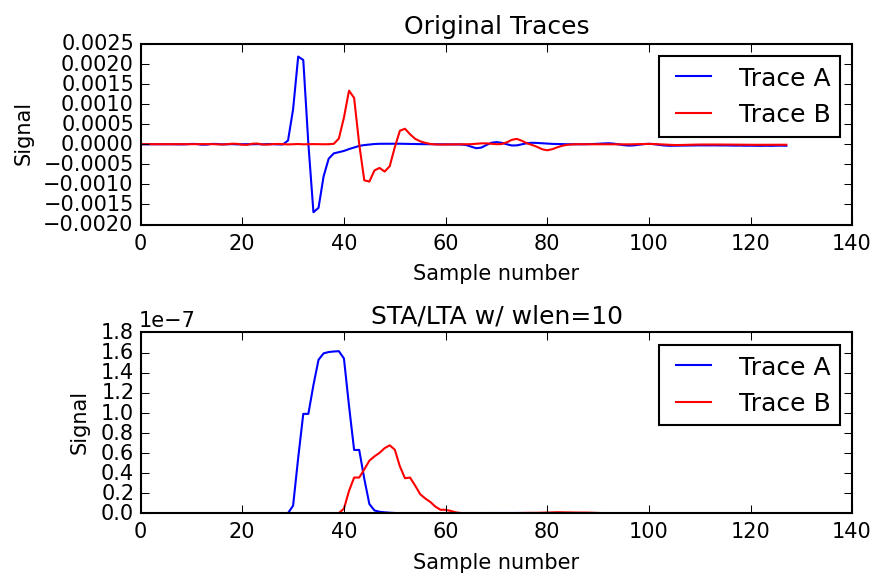

In [14]:
fig = plt.figure()

ax = fig.add_subplot(2,1,1)
ax.plot(trA, 'b', label='Trace A')
ax.plot(trB, 'r', label='Trace B')
plt.xlabel('Sample number')
plt.ylabel('Signal')
plt.title('Original Traces')
plt.legend()

ax = fig.add_subplot(2,1,2)
ax.plot(trAe, 'b', label='Trace A')
ax.plot(trBe, 'r', label='Trace B')
plt.xlabel('Sample number')
plt.ylabel('Signal')
plt.title('STA/LTA w/ wlen=%d'%(wlen,))
plt.legend()

fig.tight_layout()

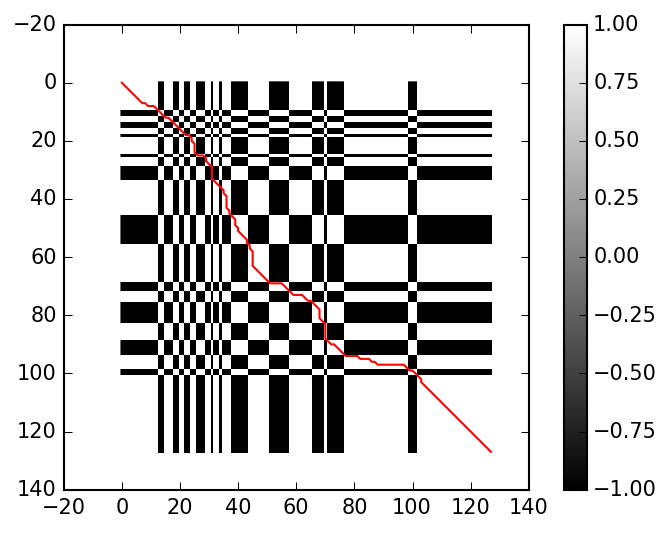

In [15]:
sim = cosineSimilarity(trA, trB)
lc = np.array(1.0-sim, order='C', dtype=float)
p, q, C, phi = dp(lc, penalty=1e-2)

fig, ax = plt.subplots()
im = ax.imshow(sim, cmap=cm.gray, interpolation='none')
plt.colorbar(im)
ax.hold(True)
ax.plot(q, p, 'r-')
ax.hold(False)

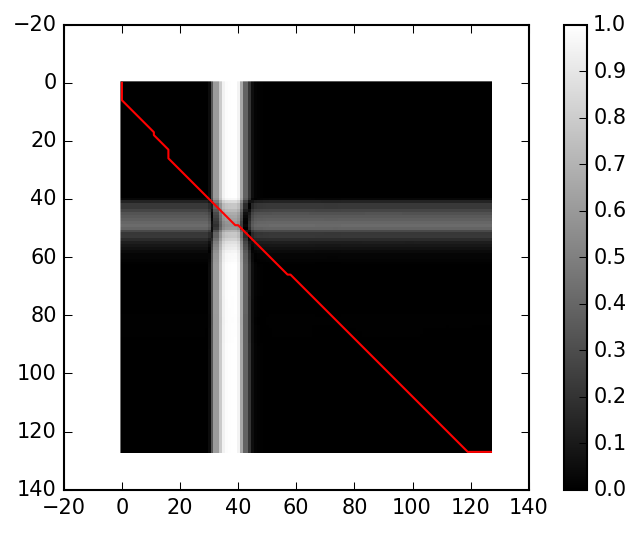

In [9]:
dif = normPosDiff(trAe, trBe)
lc = np.array(dif, order='C', dtype=float)
p, q, C, phi = dp(lc, penalty=1e-1)

fig, ax = plt.subplots()
im = ax.imshow(dif, cmap=cm.gray, interpolation='none')
plt.colorbar(im)
ax.hold(True)
ax.plot(q, p, 'r-')
ax.hold(False)

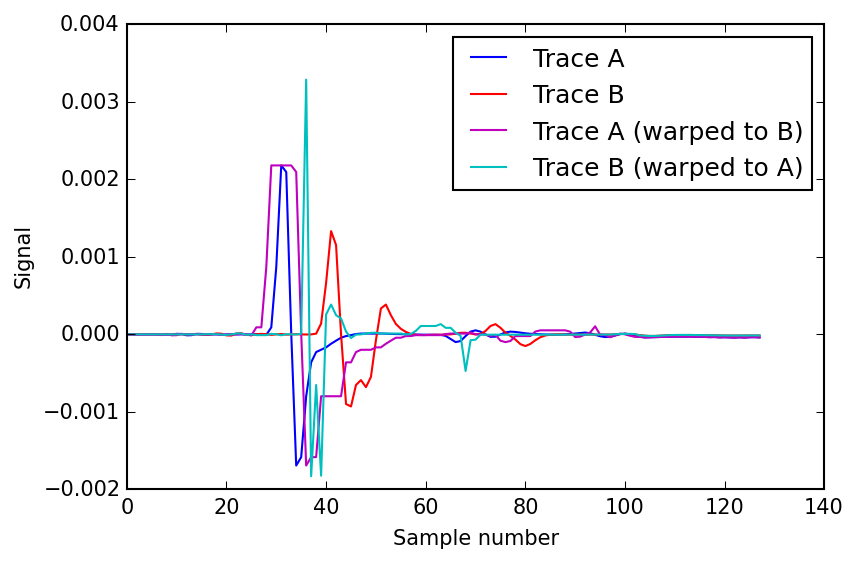

In [16]:
S = np.zeros((128,128))
for i, j in zip(p,q):
    S[i,j] = 1

fig, ax = plt.subplots()
ax.plot(trA, 'b', label='Trace A')
ax.plot(trB, 'r', label='Trace B')
ax.plot(np.dot(S, trA), 'm', label='Trace A (warped to B)')
ax.plot(np.dot(S.T, trB), 'c', label='Trace B (warped to A)')
plt.xlabel('Sample number')
plt.ylabel('Signal')
plt.legend()